In [1]:
from pandas_summary import DataFrameSummary
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from IPython.display import display

from fastai.structured import *
from fastai.imports import *

In [2]:
df_raw = pd.read_csv('./train_data.csv', low_memory=False)
df_raw.head()

,Customer ID,Applied Loan Amnt,Sacnt Loan Amnt,Sanct by Inv,Term,Interest,Grade,Employee Title,Years In Current Job,Home Ownership,Annual Income,Income Verification,Description,Purpose,Zipcode,Delinquency In Past 3years,Number of Inquiries,Month Since Last Delinquency,Number of Open Account,Deragotary Records,Total Account,Application Type,Joint Verification,Last Week Pay,Delinquent Account Count,Loan Status
0,1,4200,4200,4200.0,36 months,11.48,B,Sim-G Technologies,2 years,RENT,65000.0,Not Verified,The rate the loan I want to pay off is +20% --...,other,220xx,0.0,0.0,NaN,5.0,0.0,12.0,INDIVIDUAL,NaN,161th week,0.0,1
1,2,5000,5000,5000.0,36 months,7.26,A,Paralegal,5 years,RENT,43000.0,Source Verified,NaN,debt_consolidation,920xx,1.0,0.0,10.0,6.0,0.0,13.0,INDIVIDUAL,NaN,4th week,0.0,0
2,3,18000,18000,18000.0,36 months,6.89,A,NaN,NaN,MORTGAGE,45000.0,Verified,NaN,debt_consolidation,241xx,0.0,0.0,69.0,8.0,0.0,25.0,INDIVIDUAL,NaN,13th week,0.0,0
3,4,20000,20000,20000.0,60 months,12.29,C,Manager of Business Administration,2 years,MORTGAGE,108000.0,Not Verified,NaN,credit_card,159xx,1.0,0.0,17.0,14.0,0.0,34.0,INDIVIDUAL,NaN,17th week,0.0,0
4,5,24000,24000,24000.0,60 months,18.55,E,Superintendent,< 1 year,RENT,168000.0,Source Verified,NaN,debt_consolidation,827xx,0.0,1.0,47.0,10.0,0.0,32.0,INDIVIDUAL,NaN,35th week,0.0,0


In [3]:
df_raw.dtypes

Customer ID                       int64
Applied Loan Amnt                 int64
Sacnt Loan Amnt                   int64
Sanct by Inv                    float64
Term                             object
Interest                        float64
Grade                            object
Employee Title                   object
Years In Current Job             object
Home Ownership                   object
Annual Income                   float64
Income Verification              object
Description                      object
Purpose                          object
Zipcode                          object
Delinquency In Past 3years      float64
Number of Inquiries             float64
Month Since Last Delinquency    float64
Number of Open Account          float64
Deragotary Records              float64
Total Account                   float64
Application Type                 object
Joint Verification               object
Last Week Pay                    object
Delinquent Account Count        float64


In [4]:
df_raw.shape

(409969, 26)

In [5]:
df_raw.describe()

,Customer ID,Applied Loan Amnt,Sacnt Loan Amnt,Sanct by Inv,Interest,Annual Income,Delinquency In Past 3years,Number of Inquiries,Month Since Last Delinquency,Number of Open Account,Deragotary Records,Total Account,Delinquent Account Count,Loan Status
count,409969.000000,409969.000000,409969.000000,409969.000000,409969.000000,4.099670e+05,409958.000000,409958.000000,200191.000000,409958.000000,409958.000000,409958.000000,409958.000000,409969.000000
mean,204985.000000,14756.718069,14743.027522,14703.684400,13.249606,7.510430e+04,0.314322,0.693747,34.029976,11.546680,0.194691,25.262046,0.005003,0.235950
std,118348.000592,8431.178117,8425.511474,8437.443832,4.382580,6.813516e+04,0.859690,0.994906,21.872814,5.311206,0.582799,11.848449,0.080168,0.424591
min,1.000000,500.000000,500.000000,0.000000,5.320000,1.200000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,102493.000000,8000.000000,8000.000000,8000.000000,9.990000,4.500000e+04,0.000000,0.000000,15.000000,8.000000,0.000000,17.000000,0.000000,0.000000
50%,204985.000000,13000.000000,13000.000000,13000.000000,12.990000,6.480000e+04,0.000000,0.000000,31.000000,11.000000,0.000000,24.000000,0.000000,0.000000
75%,307477.000000,20000.000000,20000.000000,20000.000000,16.200000,9.000000e+04,0.000000,1.000000,50.000000,14.000000,0.000000,32.000000,0.000000,0.000000
max,409969.000000,35000.000000,35000.000000,35000.000000,28.990000,9.500000e+06,30.000000,31.000000,180.000000,90.000000,86.000000,162.000000,14.000000,1.000000


In [7]:
df_a = df_raw.copy()
df_a = df_a.drop(['Term', 'Grade', 'Employee Title', 'Years In Current Job',
                  'Home Ownership', 'Income Verification', 'Description',
                  'Purpose', 'Zipcode', 'Application Type', 'Joint Verification', 'Last Week Pay', 'Customer ID'], axis=1)
df_a.head()

,Applied Loan Amnt,Sacnt Loan Amnt,Sanct by Inv,Interest,Annual Income,Delinquency In Past 3years,Number of Inquiries,Month Since Last Delinquency,Number of Open Account,Deragotary Records,Total Account,Delinquent Account Count,Loan Status
0,4200,4200,4200.0,11.48,65000.0,0.0,0.0,NaN,5.0,0.0,12.0,0.0,1
1,5000,5000,5000.0,7.26,43000.0,1.0,0.0,10.0,6.0,0.0,13.0,0.0,0
2,18000,18000,18000.0,6.89,45000.0,0.0,0.0,69.0,8.0,0.0,25.0,0.0,0
3,20000,20000,20000.0,12.29,108000.0,1.0,0.0,17.0,14.0,0.0,34.0,0.0,0
4,24000,24000,24000.0,18.55,168000.0,0.0,1.0,47.0,10.0,0.0,32.0,0.0,0


In [14]:
df_a['Difference'] = df_a['Applied Loan Amnt'] - df_a['Sacnt Loan Amnt']

Applied Loan Amnt               970
Sacnt Loan Amnt                 970
Sanct by Inv                    970
Interest                        970
Annual Income                   970
Delinquency In Past 3years      970
Number of Inquiries             970
Month Since Last Delinquency    322
Number of Open Account          970
Deragotary Records              970
Total Account                   970
Delinquent Account Count        970
Loan Status                     970
Difference                      970
dtype: int64

In [16]:
df_a.drop(['Difference', 'Sacnt Loan Amnt'], axis=1,inplace=True)
df_a.describe()

,Applied Loan Amnt,Sanct by Inv,Interest,Annual Income,Delinquency In Past 3years,Number of Inquiries,Month Since Last Delinquency,Number of Open Account,Deragotary Records,Total Account,Delinquent Account Count,Loan Status
count,409969.000000,409969.000000,409969.000000,4.099670e+05,409958.000000,409958.000000,200191.000000,409958.000000,409958.000000,409958.000000,409958.000000,409969.000000
mean,14756.718069,14703.684400,13.249606,7.510430e+04,0.314322,0.693747,34.029976,11.546680,0.194691,25.262046,0.005003,0.235950
std,8431.178117,8437.443832,4.382580,6.813516e+04,0.859690,0.994906,21.872814,5.311206,0.582799,11.848449,0.080168,0.424591
min,500.000000,0.000000,5.320000,1.200000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,8000.000000,8000.000000,9.990000,4.500000e+04,0.000000,0.000000,15.000000,8.000000,0.000000,17.000000,0.000000,0.000000
50%,13000.000000,13000.000000,12.990000,6.480000e+04,0.000000,0.000000,31.000000,11.000000,0.000000,24.000000,0.000000,0.000000
75%,20000.000000,20000.000000,16.200000,9.000000e+04,0.000000,1.000000,50.000000,14.000000,0.000000,32.000000,0.000000,0.000000
max,35000.000000,35000.000000,28.990000,9.500000e+06,30.000000,31.000000,180.000000,90.000000,86.000000,162.000000,14.000000,1.000000


In [17]:
df_a['Loan Status'] = df_a['Loan Status'].astype(bool)

In [18]:
df_pro, y, nas = proc_df(df_a, 'Loan Status')

In [19]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_train = int(len(df_a)*0.3)
X_train, X_test = split_vals(df_pro, n_train)
y_train, y_test = split_vals(y, n_train)

In [40]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_features=0.5, min_samples_leaf=5)
m.fit(X_train, y_train)
m.score(X_test, y_test)

0.776454026252792

In [41]:
sklearn.metrics.f1_score(y_test, m.predict(X_test), average='weighted')

0.7134517323301793

In [42]:
fi = rf_feat_importance(m, df_pro); fi[:10]

,cols,imp
2,Interest,0.255488
3,Annual Income,0.160065
9,Total Account,0.128602
1,Sanct by Inv,0.126627
7,Number of Open Account,0.099925
0,Applied Loan Amnt,0.093518
6,Month Since Last Delinquency,0.066631
5,Number of Inquiries,0.034509
8,Deragotary Records,0.012768
14,Month Since Last Delinquency_na,0.011760


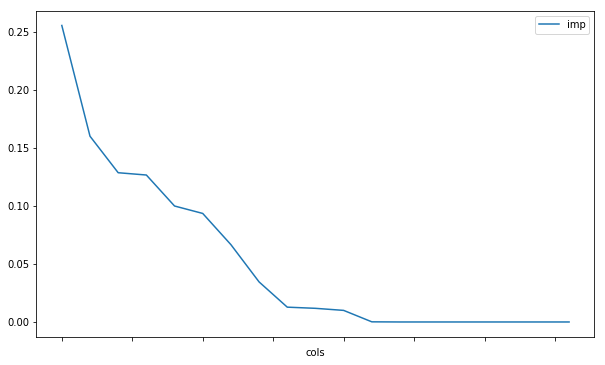

In [43]:
fi.plot('cols', 'imp', figsize=(10,6))

In [48]:
def get_pred(t): return t.predict(X_test)

preds = np.stack(parallel_trees(m, get_pred))
preds.shape

(40, 286979)

In [52]:
raw_train, raw_valid = split_vals(df_raw, int(len(df_raw)*0.3))
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().pot.barh();

AttributeError: 'DataFrame' object has no attribute 'Enclosure'